<a href="https://colab.research.google.com/github/sungbinlim/mge51101-instruct/blob/master/coursework/Lecture_8_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic time series with RNN and GRU
## Iskakov Alisher

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

### Generating synthetic time series

Let's suppose simple regression problem.

$$
f(t) = \sin(0.01t) + 0.2 \epsilon,\quad \epsilon\sim\mathcal{N}(0,1), \quad t\in [0,1000]
$$

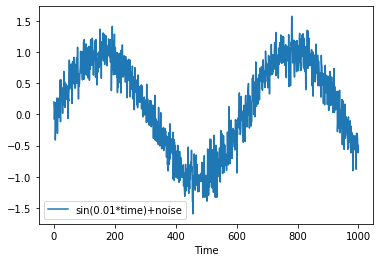

In [4]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

### AutoRegressive (AR) Model

Let's take $\tau = 4$ for `timespan` (or embedding dimension)

$$
y_{t} = x_{t},\quad \mathbf{z}_{t}(x_{t-1},\ldots, x_{t-\tau})
$$

In [5]:
# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 4
features = torch.zeros((T-tau, tau)) # AR Model needs tau inputs: shape is (996, 4)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)]
labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

### MLP

In [7]:
# Parameter Initialization
def init_weight(map_):
    if type(map_) == nn.Linear:
        torch.nn.init.xavier_uniform_(map_.weight)

# Vanilla MLP architecture
def MLP():
    net = nn.Sequential()
    net.add_module("Linear_1", nn.Linear(tau, 10, bias=False))
    net.add_module("ReLU", nn.ReLU())
    net.add_module("Final", nn.Linear(10, 1, bias=False))
    net.apply(init_weight)

    return net

In [47]:
# Least mean squares loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

# textbook code
def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            output = net(x)
            loss = criterion(output, y.reshape(-1, 1))
            loss.backward()
            optim.step()
            running_loss += loss.item()
        
        print("epoch: {}, loss: {:.2f}".format(epoch, running_loss))
    
    test_loss = criterion(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
    print('test loss: %f' % test_loss.mean().detach().numpy())

    return net
    
net = MLP()
net = train_net(net, train_data, criterion, 10, 0.01)

epoch: 1, loss: 2.65
epoch: 2, loss: 2.05
epoch: 3, loss: 2.03
epoch: 4, loss: 2.03
epoch: 5, loss: 2.05
epoch: 6, loss: 2.12
epoch: 7, loss: 1.95
epoch: 8, loss: 1.96
epoch: 9, loss: 1.99
epoch: 10, loss: 2.05
test loss: 0.047403


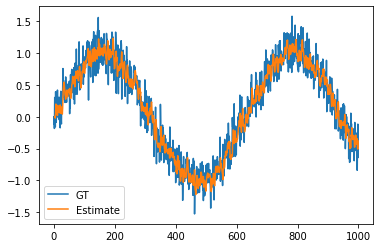

In [48]:
estimates = net(features)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimates.detach().numpy(), label='Estimate');
plt.legend();

### Why forecasting is not simple

In reality, for $t > 600$, we cannot use $x_{t}$ in AR. Instead we have to use $\hat{x}_{t}$ recursively:

$$
\begin{aligned}
\hat{x}_{601} &= f(x_{600}, x_{599}, x_{598}, x_{597}) \\  
\hat{x}_{602} &= f(\hat{x}_{601}, x_{600}, x_{599}, x_{598}) \\
\hat{x}_{603} &= f(\hat{x}_{602}, \hat{x}_{601}, x_{600}, x_{599}) \\
\hat{x}_{604} &= f(\hat{x}_{603}, \hat{x}_{602}, \hat{x}_{601}, x_{600})
\end{aligned}
$$

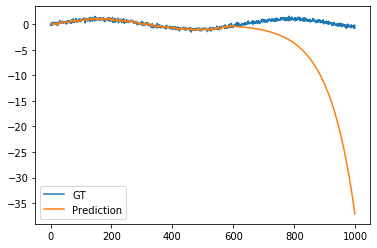

In [64]:
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    predictions[i] = net(
        predictions[(i - tau):i].reshape(1, -1)
    ).reshape(1)

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction');
plt.legend();

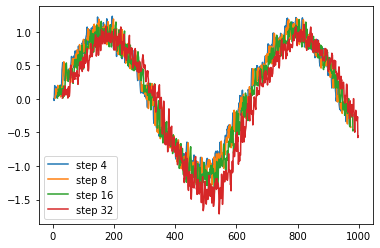

In [65]:
k = 33  # Look up to k - tau steps ahead

features = torch.zeros((T-k, k))
for i in range(tau):
    features[:, i] = X[i:T-k+i]

for i in range(tau, k):
    features[:, i] = net(features[:,(i-tau):i]).reshape((-1))

for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i].numpy(), features[:, i].detach().numpy(),
             label=('step ' + str(i)))
plt.legend();

## Recurrent Neural Networks

We use the following setting

$$
p(x_{t}|x_{t-1},\ldots, x_{1}) \approx p(x_{t}|x_{t-1}, h_{t})
$$

Here $h_{t}$ is a latent variable that stores the sequence information:

$$
h_{t} = f(x_{t}, h_{t-1})
$$

### RNN

In [32]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.rnn(inputs, hidden)
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### GRU

In [33]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.gru(inputs, hidden)
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Language Example using `torch.nn.RNN`

In [12]:
string = "hello pytorch? deep learning is fun!"
chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;01"
char_list = [char for char in chars]

In [13]:
char_len = len(char_list)
string_len = len(string)

def string_to_onehot(string):
    """
    String to onehot vector
    a -> [1 0 0 ... 0 0]
    """
    start = np.zeros(shape=char_len ,dtype=int)
    end = np.zeros(shape=char_len ,dtype=int)
    start[-2] = 1
    end[-1] = 1
    for s in string:
        idx = char_list.index(s)
        zero = np.zeros(shape=char_len ,dtype=int)
        zero[idx]=1
        start = np.vstack([start,zero])
    output = np.vstack([start,end])
    return output

def onehot_to_word(onehot):
    """
    Onehot vector to word
    [1 0 0 ... 0 0] -> a 
    """
    onehot = torch.Tensor.numpy(onehot)
    return char_list[onehot.argmax()]

one_hot = torch.tensor(string_to_onehot(string), dtype=torch.float)

In [34]:
# Hyperparameters
n_hidden = 37
lr = 0.01
epochs = 200

model = RNN(char_len, n_hidden, 1, char_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [52]:
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0
    hidden = model.initHidden()

    for idx in range(one_hot.size()[0]-1):
        inputs = one_hot[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        target = one_hot[idx+1]
        loss = criterion(output.view(-1),target.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 2.24471
loss: 0.01081


In [53]:
hidden = model.initHidden()
inputs = one_hot[0:1,:].reshape(1, 1, -1)

for i in range(string_len):
    output, hidden = model(inputs, hidden)
    print(onehot_to_word(output.data), end="")
    inputs = output

hello pytorch? deep learnilg lnarnpr